**Import required libraries**


In [132]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

**Configuration**


In [123]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

TEST_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 200
PLOT_STEP=50
HIDDEN = 16
LR = 1e-3

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


**Data Preparation**


In [124]:
def target_function(x):
    """
    We want our neural networks to learn to approximate the function
    y = e^(-x^2)
    """
    return np.exp(-x**2)


In [125]:
def create_sample_data(left=-10, right=10, step=0.01):
    # Uniform grid from left to right (inclusive)
    n = int(round((right - left) / step)) + 1
    x = np.linspace(left, right, n, dtype=float)
    return x


In [126]:
X = create_sample_data()
Y = target_function(X)

**Visualise our data**


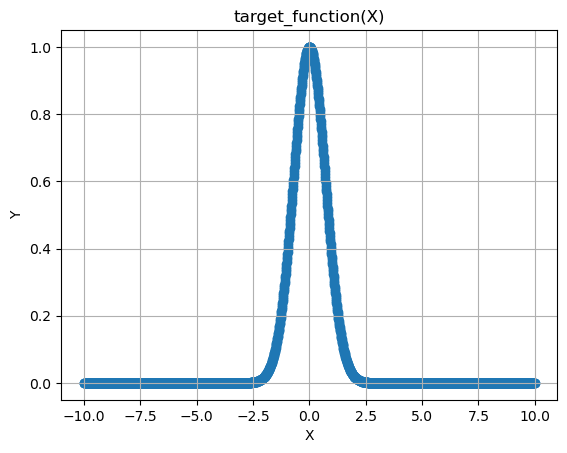

In [127]:
plt.scatter(X, Y, marker='o', linewidth=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('target_function(X)')
plt.grid(True)
plt.show()


**Train-Test Splitting**


In [128]:
X_train, X_test, y_train, y_test = train_test_split(
    X.reshape(-1, 1), Y, test_size=TEST_SIZE, random_state=SEED
)

In [129]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE * 2, shuffle=False)

**Define our simple feed forward neural networks**


In [130]:
class SimpleDNN(nn.Module):
    def __init__(self, hidden=16):
        super().__init__()
        # 1 input -> hidden -> output
        self.fc1 = nn.Linear(1, hidden)
        self.act = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden, 1)

    def forward(self, x):
        x = self.act(self.fc1(x))
        return self.fc2(x)


**Training, Evaluation, and Plotting**


Epoch 050 | Train MSE: 0.002953 | Test MSE: 0.002813
Epoch 100 | Train MSE: 0.000086 | Test MSE: 0.000082
Epoch 150 | Train MSE: 0.000022 | Test MSE: 0.000021
Epoch 200 | Train MSE: 0.000005 | Test MSE: 0.000004


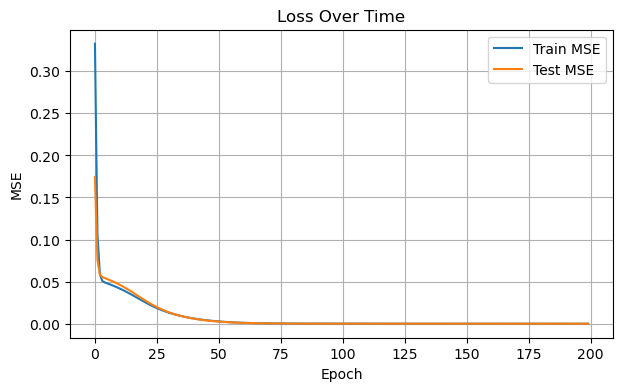

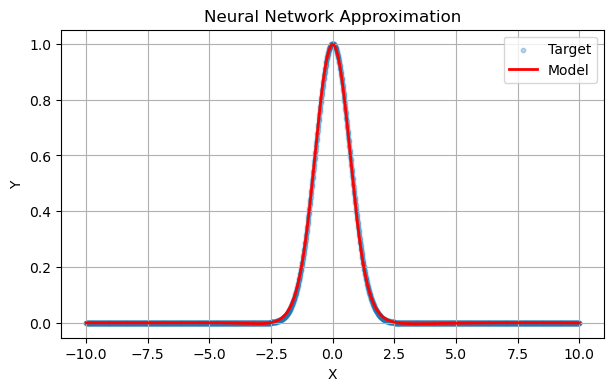

In [131]:
# Model, loss, optimizer
model = SimpleDNN(hidden=HIDDEN).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training loop
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            preds = model(xb)
            test_loss += criterion(preds, yb).item() * xb.size(0)
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    if (epoch + 1) % PLOT_STEP == 0:
        print(f'Epoch {epoch+1:03d} | Train MSE: {train_loss:.6f} | Test MSE: {test_loss:.6f}')

# Plot loss over time
plt.figure(figsize=(7, 4))
plt.plot(train_losses, label='Train MSE')
plt.plot(test_losses, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Loss Over Time')
plt.grid(True)
plt.legend()
plt.show()

# Plot predictions vs target function
X_all = torch.tensor(X.reshape(-1, 1), dtype=torch.float32, device=DEVICE)
model.eval()
with torch.no_grad():
    y_pred = model(X_all).cpu().numpy().squeeze()

plt.figure(figsize=(7, 4))
plt.scatter(X, Y, s=10, alpha=0.3, label='Target')
plt.plot(X, y_pred, color='red', linewidth=2, label='Model')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Neural Network Approximation')
plt.grid(True)
plt.legend()
plt.show()